<a href="https://colab.research.google.com/github/drkbluescience/UrbanSoundClassification/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [18]:
import os
os.chdir("/gdrive/MyDrive/UrbanSoundClassification/")

In [19]:
import pickle
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
import itertools
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt

In [20]:
# Get dataset

pickle_file_link = "dataset/"
x_train = pickle.load(open(f"{pickle_file_link}/x_train.pickle","rb"))
y_train = pickle.load(open(f"{pickle_file_link}/y_train.pickle","rb"))

x_test = pickle.load(open(f"{pickle_file_link}/x_test.pickle","rb"))
y_test = pickle.load(open(f"{pickle_file_link}/y_test.pickle","rb"))

x_val = pickle.load(open(f"{pickle_file_link}/x_val.pickle","rb"))
y_val = pickle.load(open(f"{pickle_file_link}/y_val.pickle","rb"))

In [21]:
import numpy as np
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)
x_train = np.reshape (x_train, (len(x_train), 128, 128, 1))
x_val =  np.reshape (x_val, (len(x_val), 128, 128, 1))
x_test =  np.reshape (x_test, (len(x_test), 128, 128, 1))
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)

(5588, 128, 128)
(1397, 128, 128)
(1747, 128, 128)
(5588, 128, 128, 1)
(5588,)
(1397, 128, 128, 1)


In [22]:
x_train = x_train.reshape(-1, 128, 128, 1)
x_test = x_test.reshape(-1, 128, 128, 1)

print('Train:', x_train.shape)
print('Test:', x_test.shape)

Train: (5588, 128, 128, 1)
Test: (1747, 128, 128, 1)


In [23]:
model = Sequential()

# Layer 1
model.add(Conv2D(64, 3, data_format="channels_last", kernel_initializer="he_normal", input_shape=(128,128,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# Layer 2
model.add(Conv2D(64, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.6)) 
# Layer 3
model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))


# Layer 4
model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))

#Layer 5
model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.6)) 

#fully Connected Layer
model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.6)) #

#Output Layer
model.add(Dense(10))
model.add(Activation('softmax')) 

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 126, 126, 64)      640       
                                                                 
 batch_normalization_6 (Batc  (None, 126, 126, 64)     256       
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 126, 126, 64)      0         
                                                                 
 conv2d_13 (Conv2D)          (None, 124, 124, 64)      36928     
                                                                 
 batch_normalization_7 (Batc  (None, 124, 124, 64)     256       
 hNormalization)                                                 
                                                                 
 activation_8 (Activation)   (None, 124, 124, 64)     

In [24]:
# save the best weights
checkpointer = ModelCheckpoint(filepath='models/sound_model1.h5', verbose=1, save_best_only=True)

epochs = 30
batchSize = 32

# run the model

hist = model.fit(x_train, y_train,
                 epochs=epochs,
                 shuffle=True,
                 batch_size=batchSize,
                 validation_data=(x_val, y_val),
                 callbacks=[checkpointer], verbose=2)
                
# save model to json
model_json = model.to_json()
with open('models/sound_model1.json', 'w') as json_file:
  json_file.write(model_json)

Epoch 1/30

Epoch 1: val_loss improved from inf to 1.36223, saving model to models/sound_model1.h5
175/175 - 15s - loss: 1.6743 - accuracy: 0.4381 - val_loss: 1.3622 - val_accuracy: 0.5347 - 15s/epoch - 83ms/step
Epoch 2/30

Epoch 2: val_loss improved from 1.36223 to 1.02562, saving model to models/sound_model1.h5
175/175 - 14s - loss: 1.1580 - accuracy: 0.6052 - val_loss: 1.0256 - val_accuracy: 0.6535 - 14s/epoch - 80ms/step
Epoch 3/30

Epoch 3: val_loss did not improve from 1.02562
175/175 - 12s - loss: 0.9452 - accuracy: 0.6890 - val_loss: 1.1588 - val_accuracy: 0.5784 - 12s/epoch - 71ms/step
Epoch 4/30

Epoch 4: val_loss improved from 1.02562 to 0.99617, saving model to models/sound_model1.h5
175/175 - 13s - loss: 0.8002 - accuracy: 0.7369 - val_loss: 0.9962 - val_accuracy: 0.6764 - 13s/epoch - 76ms/step
Epoch 5/30

Epoch 5: val_loss improved from 0.99617 to 0.56175, saving model to models/sound_model1.h5
175/175 - 12s - loss: 0.6768 - accuracy: 0.7831 - val_loss: 0.5617 - val_accu

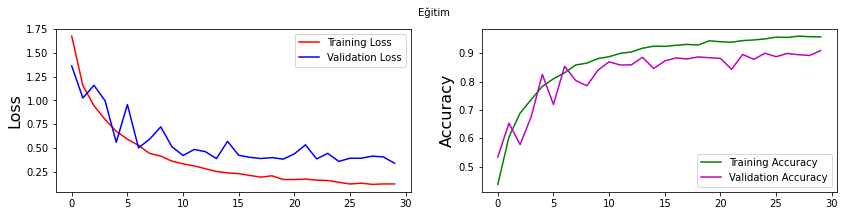

In [25]:
plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.suptitle('Eğitim', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], color ='r', label='Training Loss')
plt.plot(hist.history['val_loss'], color ='b', label='Validation Loss')
plt.legend(loc='upper right')


plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['accuracy'], color ='g', label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], color ='m', label='Validation Accuracy')
plt.legend(loc='lower right')

plt.show()

In [26]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test Loss:', score[0])
print('Test Accuracy:', score[1])

Test Loss: 0.31832125782966614
Test Accuracy: 0.9152833223342896


In [27]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

epochs = 30
batchSize = 32

# run the model

hist = model.fit(x_train, y_train,
                 epochs=epochs,
                 shuffle=True,
                 batch_size=batchSize,
                 validation_data=(x_val, y_val),
                 callbacks=[stop_early], verbose=2)

Epoch 1/30
175/175 - 12s - loss: 0.1218 - accuracy: 0.9615 - val_loss: 0.4026 - val_accuracy: 0.8941 - 12s/epoch - 70ms/step
Epoch 2/30
175/175 - 12s - loss: 0.1127 - accuracy: 0.9619 - val_loss: 0.4316 - val_accuracy: 0.8955 - 12s/epoch - 70ms/step
Epoch 3/30
175/175 - 12s - loss: 0.1137 - accuracy: 0.9594 - val_loss: 0.5409 - val_accuracy: 0.8747 - 12s/epoch - 70ms/step
Epoch 4/30
175/175 - 12s - loss: 0.1153 - accuracy: 0.9596 - val_loss: 0.4609 - val_accuracy: 0.8862 - 12s/epoch - 70ms/step
Epoch 5/30
175/175 - 13s - loss: 0.1097 - accuracy: 0.9642 - val_loss: 0.3863 - val_accuracy: 0.9055 - 13s/epoch - 72ms/step
Epoch 6/30
175/175 - 13s - loss: 0.1004 - accuracy: 0.9687 - val_loss: 0.3784 - val_accuracy: 0.8976 - 13s/epoch - 72ms/step
Epoch 7/30
175/175 - 12s - loss: 0.0956 - accuracy: 0.9665 - val_loss: 0.4804 - val_accuracy: 0.8926 - 12s/epoch - 70ms/step
Epoch 8/30
175/175 - 12s - loss: 0.0916 - accuracy: 0.9678 - val_loss: 0.4840 - val_accuracy: 0.8833 - 12s/epoch - 70ms/step


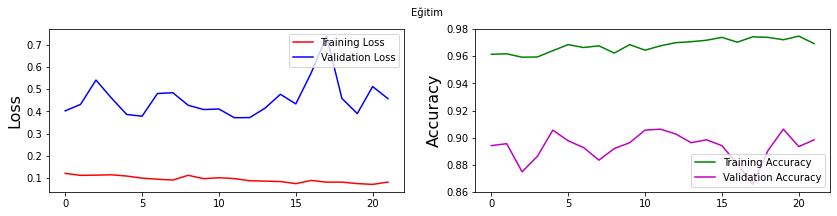

In [28]:
plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.suptitle('Eğitim', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], color ='r', label='Training Loss')
plt.plot(hist.history['val_loss'], color ='b', label='Validation Loss')
plt.legend(loc='upper right')


plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['accuracy'], color ='g', label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], color ='m', label='Validation Accuracy')
plt.legend(loc='lower right')

plt.show()

In [29]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test Loss:', score[0])
print('Test Accuracy:', score[1])

Test Loss: 0.39720895886421204
Test Accuracy: 0.9009730815887451
